## Introduction to project



### Content: 
* [Data cleaning and first exploration](#1)
* [Getting the Benchmark](#2)
* [Explore Other Clasifiers](#3)
* [The Classifier - Model](#4)
* [Conclusion](#5)

### Import Libraries & Data

In [171]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
pd.set_option('display.max_colwidth', 100)

stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()
wn = nltk.WordNetLemmatizer()

data = pd.read_csv("Reviews_of_Amazon_Products_2.csv")
data.head()


asins  reviews.rating  \
0  B00QWO9P0O,B00LH3DMUO               3   
1  B00QWO9P0O,B00LH3DMUO               4   
2  B00QWO9P0O,B00LH3DMUO               5   
3  B00QWO9P0O,B00LH3DMUO               5   
4  B00QWO9P0O,B00LH3DMUO               5   

                                                                                          reviews.text  
0  I order 3 of them and one of the item is bad quality. Is missing backup spring so I have to put ...  
1                                  Bulk is always the less expensive way to go for products like these  
2                                             Well they are not Duracell but for the price i am happy.  
3                                  Seem to work as well as name brand batteries at a much better price  
4                                            These batteries are very long lasting the price is great.

<a id ='1' ></a>
### EDA - Data Preprocessing 

In [164]:
#Make a copy of data,detangle the product ids and reset index
df = data.copy()
df['asins'] = df['asins'].apply(lambda x: x.split(','))
df = df.explode('asins')
df = df.set_index('asins')
  
df.head()

reviews.rating  \
asins                        
B00QWO9P0O               3   
B00LH3DMUO               3   
B00QWO9P0O               4   
B00LH3DMUO               4   
B00QWO9P0O               5   

                                                                                                   reviews.text  
asins                                                                                                            
B00QWO9P0O  I order 3 of them and one of the item is bad quality. Is missing backup spring so I have to put ...  
B00LH3DMUO  I order 3 of them and one of the item is bad quality. Is missing backup spring so I have to put ...  
B00QWO9P0O                                  Bulk is always the less expensive way to go for products like these  
B00LH3DMUO                                  Bulk is always the less expensive way to go for products like these  
B00QWO9P0O                                             Well they are not Duracell but for the price i am happy.

In [3]:
#Standardize columns
standard_columns = [col_name.replace('.', '_') for col_name in df.columns]
df.columns = standard_columns

In [4]:
#What is the shape of the dataset
print("Input data has {} rows and {} columns".format(len(df), len(df.columns)))

Input data has 46774 rows and 2 columns


In [5]:
# How much missing data is there?

print("Number of null in Reviews: {}".format(df['reviews_text'].isnull().sum()))
print("Number of null in Reviews Rating: {}".format(df['reviews_rating'].isnull().sum()))

Number of null in Reviews: 0
Number of null in Reviews Rating: 0


In [6]:
# Take a peek into the Review text
df['reviews_text'][0]

'I order 3 of them and one of the item is bad quality. Is missing backup spring so I have to put a pcs of aluminum to make the battery work.'

#### Feature Extraction - Clean & Classify reviews sentiment using vader Sentiment analyzer tool

In [7]:
# Cleaning and Tokenizing text

def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [wn.lemmatize(word) for word in tokens if word not in stopwords]
    return text


In [8]:
#Get review classification 
def review_classifier(x):
    analyzer = SentimentIntensityAnalyzer()
    review_scores = [analyzer.polarity_scores(sentence)['compound'] for sentence in list(x)]
    return ['Satisfied' if score>=0.05 and score<=0.25
            else 'Happy' if (score>0.25 and score<=0.65)
            else 'Very Happy' if score>0.65
            else 'Indifferent' if (score>-0.05 and score<=0.05)
            else 'Disappointed' for score in review_scores]


In [9]:
#Apply function to feature for extraction
df['emotions'] = review_classifier(df['reviews_text'])

In [10]:
#Drop this feature
df.drop(columns= 'reviews_rating',axis=1, inplace=True)

In [12]:
#Take a peek into the classifications for confirmation
df[df['emotions']=='Very Happy'].head()

reviews_text  \
asins                                                                                                             
B00QWO9P0O                                             Well they are not Duracell but for the price i am happy.   
B00LH3DMUO                                             Well they are not Duracell but for the price i am happy.   
B00QWO9P0O  Bought a lot of batteries for Christmas and the AmazonBasics Cell have been good. I haven't noti...   
B00LH3DMUO  Bought a lot of batteries for Christmas and the AmazonBasics Cell have been good. I haven't noti...   
B00QWO9P0O  Well if you are looking for cheap non-rechargeable batteries that last quite a while then these ...   

              emotions  
asins                   
B00QWO9P0O  Very Happy  
B00LH3DMUO  Very Happy  
B00QWO9P0O  Very Happy  
B00LH3DMUO  Very Happy  
B00QWO9P0O  Very Happy

<a id ='2' ></a>
### Getting  Benchmark

#### Apply TfidfVectorizer to encode text(Vectorization)

In [14]:
tfidf_vector = TfidfVectorizer(analyzer=clean_text, ngram_range=(1, 5), sublinear_tf=True)
X_tfidf = tfidf_vector.fit_transform(df['reviews_text'])


print(X_tfidf.shape)
print(tfidf_vector.get_feature_names())

(46774, 11675)
['', '0', '01162017', '015', '021ea', '022', '022027', '025', '025050', '031ea', '033', '034', '043', '085', '09', '09500043200', '0f', '0v', '1', '10', '100', '1000', '10000', '100240', '1005', '100battery', '100ish', '100pack', '100this', '100v240v', '101', '1010', '1012', '1015', '101and', '102015', '1022mm', '105', '1080', '1080p', '10and', '10day', '10in', '10pack', '10paksgreat', '10pk', '10th', '10x', '10year', '10yearold', '10yr', '11', '110', '1102017not', '110v', '110w', '1112gb', '112', '112018', '112026', '112816', '1132017', '115f', '116', '11716', '11dec2015', '11year', '11yr', '12', '120', '1200', '1208', '120ea', '120is', '122026', '12212016update', '12416', '1249', '125', '125v', '127im', '128', '1280800', '128gb', '128gbi', '129', '12999', '12days', '12pack', '12packs', '12x', '13', '1300', '13000', '133', '139', '1397', '13k', '13th', '13v', '14', '144', '1440', '145', '146146125v', '148v', '14cant', '14pounds', '14yo', '15', '150', '15000', '1520', '1

C:\Users\49178\anaconda3\envs\final_project\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Apply TfidfVectorizer to smaller sample to take a peek

In [14]:
df_sample = df[0:20]

tfidf_vector_sample = TfidfVectorizer(analyzer=clean_text, ngram_range=(1, 5), sublinear_tf=True)
X_tfidf_sample = tfidf_vector_sample.fit_transform(df_sample['reviews_text'])
print(X_tfidf_sample.shape)
print(tfidf_vector_sample.get_feature_names())

(20, 79)
['3', 'aa', 'aaa', 'aluminum', 'always', 'amazon', 'amazonbasics', 'amount', 'appear', 'arrive', 'backup', 'bad', 'basic', 'battery', 'better', 'bought', 'brand', 'bulk', 'buy', 'cell', 'cheap', 'christmas', 'difference', 'done', 'duracell', 'easier', 'energizer', 'expensive', 'go', 'good', 'great', 'half', 'hand', 'happy', 'havent', 'high', 'hold', 'house', 'ill', 'item', 'ive', 'juice', 'last', 'lasting', 'le', 'life', 'like', 'long', 'looking', 'lot', 'make', 'missing', 'much', 'name', 'nonrechargeable', 'nothing', 'noticed', 'one', 'order', 'ordered', 'past', 'pc', 'perfect', 'pleased', 'power', 'price', 'problame', 'product', 'purchase', 'put', 'quality', 'quite', 'say', 'seem', 'shelf', 'spring', 'way', 'well', 'work']


In [18]:
# Convert sparsed matrix to Dataframe for better view of the sample data frame
X_tfidf_df = pd.DataFrame(X_tfidf_sample.toarray())
X_tfidf_df.columns = tfidf_vector_sample.get_feature_names_out()
X_tfidf_df

3        aa       aaa  aluminum    always   amazon  amazonbasics  \
0   0.268326  0.000000  0.000000  0.268326  0.000000  0.00000      0.000000   
1   0.268326  0.000000  0.000000  0.268326  0.000000  0.00000      0.000000   
2   0.000000  0.000000  0.000000  0.000000  0.360767  0.00000      0.000000   
3   0.000000  0.000000  0.000000  0.000000  0.360767  0.00000      0.000000   
4   0.000000  0.000000  0.000000  0.000000  0.000000  0.00000      0.000000   
5   0.000000  0.000000  0.000000  0.000000  0.000000  0.00000      0.000000   
6   0.000000  0.000000  0.000000  0.000000  0.000000  0.00000      0.000000   
7   0.000000  0.000000  0.000000  0.000000  0.000000  0.00000      0.000000   
8   0.000000  0.000000  0.000000  0.000000  0.000000  0.00000      0.000000   
9   0.000000  0.000000  0.000000  0.000000  0.000000  0.00000      0.000000   
10  0.000000  0.000000  0.000000  0.000000  0.000000  0.21745      0.179744   
11  0.000000  0.000000  0.000000  0.000000  0.000000  0.21745      0.179744   
12  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000      0.000000   
13  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000      0.000000   
14  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000      0.000000   
15  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000      0.000000   
16  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000      0.000000   
17  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000      0.000000   
18  0.000000  0.321931  0.321931  0.000000  0.000000  0.00000      0.266108   
19  0.000000  0.321931  0.321931  0.000000  0.000000  0.00000      0.266108   

      amount    appear   arrive  ...       put   quality     quite       say  \
0   0.000000  0.000000  0.00000  ...  0.268326  0.268326  0.000000  0.000000   
1   0.000000  0.000000  0.00000  ...  0.268326  0.268326  0.000000  0.000000   
2   0.000000  0.000000  0.00000  ...  0.000000  0.000000  0.000000  0.000000   
3   0.000000  0.000000  0.00000  ...  0.000000  0.000000  0.000000  0.000000   
4   0.000000  0.000000  0.00000  ...  0.000000  0.000000  0.000000  0.000000   
5   0.000000  0.000000  0.00000  ...  0.000000  0.000000  0.000000  0.000000   
6   0.000000  0.000000  0.00000  ...  0.000000  0.000000  0.000000  0.000000   
7   0.000000  0.000000  0.00000  ...  0.000000  0.000000  0.000000  0.000000   
8   0.000000  0.000000  0.00000  ...  0.000000  0.000000  0.000000  0.000000   
9   0.000000  0.000000  0.00000  ...  0.000000  0.000000  0.000000  0.000000   
10  0.000000  0.000000  0.21745  ...  0.000000  0.000000  0.000000  0.000000   
11  0.000000  0.000000  0.21745  ...  0.000000  0.000000  0.000000  0.000000   
12  0.000000  0.000000  0.00000  ...  0.000000  0.000000  0.000000  0.000000   
13  0.000000  0.000000  0.00000  ...  0.000000  0.000000  0.000000  0.000000   
14  0.000000  0.000000  0.00000  ...  0.000000  0.000000  0.341016  0.341016   
15  0.000000  0.000000  0.00000  ...  0.000000  0.000000  0.341016  0.341016   
16  0.337874  0.000000  0.00000  ...  0.000000  0.000000  0.000000  0.000000   
17  0.337874  0.000000  0.00000  ...  0.000000  0.000000  0.000000  0.000000   
18  0.000000  0.321931  0.00000  ...  0.000000  0.000000  0.000000  0.000000   
19  0.000000  0.321931  0.00000  ...  0.000000  0.000000  0.000000  0.000000   

        seem     shelf    spring       way      well      work  
0   0.000000  0.000000  0.268326  0.000000  0.000000  0.221798  
1   0.000000  0.000000  0.268326  0.000000  0.000000  0.221798  
2   0.000000  0.000000  0.000000  0.360767  0.000000  0.000000  
3   0.000000  0.000000  0.000000  0.360767  0.000000  0.000000  
4   0.000000  0.000000  0.000000  0.000000  0.399020  0.000000  
5   0.000000  0.000000  0.000000  0.000000  0.399020  0.000000  
6   0.406825  0.000000  0.000000  0.000000  0.255109  0.336281  
7   0.406825  0.000000  0.000000  0.000000  0.255109  0.336281  
8   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
9   0.000000  0.0000

In [44]:
df_array = X_tfidf.toarray()

In [45]:
#Reduce Dimension of features to 55 and check to get the array of the sparsed matrix
svd = TruncatedSVD(n_components=55)
svd.fit(df_array)
df_array_transformed = svd.fit_transform(df_array)
df_array_transformed

(46774, 11675)


array([[ 0.09336869,  0.00291277,  0.10905824, ..., -0.0024184 ,
         0.02833485, -0.05618597],
       [ 0.09336869,  0.00291277,  0.10905824, ..., -0.0024184 ,
         0.02833485, -0.05618597],
       [ 0.07173948, -0.00200262,  0.04224094, ...,  0.05549049,
        -0.04125828, -0.00045565],
       ...,
       [ 0.12899368,  0.09609925,  0.00557858, ..., -0.02248136,
        -0.01116389,  0.01497497],
       [ 0.02859521, -0.00598369,  0.02337158, ...,  0.00939324,
        -0.01766751, -0.02334101],
       [ 0.10959952,  0.12535443, -0.00139382, ..., -0.01521751,
        -0.01476988,  0.02287094]])

In [46]:
#Confirm reduced dimension
df_array_transformed.shape

(46774, 55)

In [47]:
#Convert array to dataframe
X_features1 = pd.DataFrame(df_array_transformed)
X_features1.head()

0         1         2         3         4         5         6   \
0  0.093369  0.002913  0.109058  0.048729  0.017686 -0.014118  0.049754   
1  0.093369  0.002913  0.109058  0.048729  0.017686 -0.014118  0.049754   
2  0.071739 -0.002003  0.042241 -0.030889  0.077079 -0.008035 -0.022858   
3  0.071739 -0.002003  0.042241 -0.030889  0.077079 -0.008035 -0.022858   
4  0.187807 -0.010289  0.059314  0.010254 -0.028726 -0.205541 -0.148055   

         7         8         9   ...        45        46        47        48  \
0  0.024837  0.017717 -0.017800  ...  0.016916  0.000618  0.073683 -0.064255   
1  0.024837  0.017717 -0.017800  ...  0.016916  0.000618  0.073683 -0.064255   
2 -0.056750  0.251206  0.019655  ... -0.030414  0.077983  0.029484 -0.062353   
3 -0.056750  0.251206  0.019655  ... -0.030414  0.077983  0.029484 -0.062353   
4  0.157864  0.004963  0.130848  ...  0.004190 -0.109338  0.160678  0.054039   

         49        50        51        52        53        54  
0 -0.078288 -0.040110  0.071897 -0.002418  0.028335 -0.056186  
1 -0.078288 -0.040110  0.071897 -0.002418  0.028335 -0.056186  
2  0.030769 -0.035277  0.063570  0.055490 -0.041258 -0.000456  
3  0.030769 -0.035277  0.063570  0.055490 -0.041258 -0.000456  
4  0.098266  0.043561 -0.084887 -0.069241 -0.194429 -0.061747  

[5 rows x 55 columns]

Check RandomForestClassifier through k-fold Cross-Validation on Fisrt DF

In [48]:
#K-fold Cross-Validation 
rf = RandomForestClassifier(n_jobs=-1)
k_fold = KFold(n_splits=5)
cross_val_score(rf, X_features1, df['emotions'], cv=k_fold, scoring='accuracy', n_jobs=-1)

array([0.75456975, 0.70946018, 0.83303046, 0.92185997, 0.88379303])

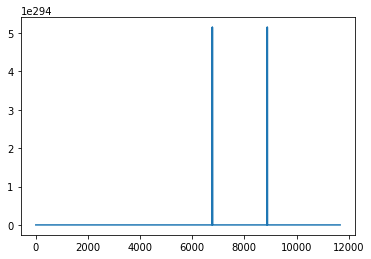

In [32]:
#Get the number of components that should be used using SVD for dimensionality reduction
U, D, VT =  np.linalg.svd(df_array)
plt.plot(D)
plt.show()

We see a proposed dimension of about 8,400 features. But that is too high still. So we will reduce to 300 features instead and see if we get something better

In [18]:
#SVD for 300 components instead
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=300)
svd.fit(df_array)
df_array_transformed2 = svd.fit_transform(df_array)
df_array_transformed2

array([[ 0.09336869,  0.00291277,  0.10905825, ...,  0.01009437,
         0.00433878,  0.01353108],
       [ 0.09336869,  0.00291277,  0.10905825, ...,  0.01009437,
         0.00433878,  0.01353108],
       [ 0.07173948, -0.00200262,  0.04224075, ..., -0.01711381,
        -0.04108047,  0.01158478],
       ...,
       [ 0.12899368,  0.09609924,  0.00557859, ...,  0.00388418,
         0.0131913 , -0.01923772],
       [ 0.02859521, -0.00598369,  0.02337151, ..., -0.06058069,
         0.00582859,  0.00184865],
       [ 0.10959952,  0.12535444, -0.00139391, ...,  0.03547864,
         0.04993361, -0.04085111]])

In [19]:
#Confirm the new shape of data
df_array_transformed2.shape

(46774, 300)

In [20]:
X_features2 = pd.DataFrame(df_array_transformed2)
X_features2.head()

0         1         2         3         4         5         6    \
0  0.093369  0.002913  0.109058  0.048729  0.017685 -0.014119  0.049751   
1  0.093369  0.002913  0.109058  0.048729  0.017685 -0.014119  0.049751   
2  0.071739 -0.002003  0.042241 -0.030890  0.077078 -0.008034 -0.022864   
3  0.071739 -0.002003  0.042241 -0.030890  0.077078 -0.008034 -0.022864   
4  0.187807 -0.010289  0.059314  0.010255 -0.028723 -0.205541 -0.148057   

        7         8         9    ...       290       291       292       293  \
0  0.024835  0.017707 -0.017810  ...  0.021195  0.000914  0.003548 -0.014353   
1  0.024835  0.017707 -0.017810  ...  0.021195  0.000914  0.003548 -0.014353   
2 -0.056749  0.251197  0.019763  ...  0.037787  0.016286 -0.002090 -0.022498   
3 -0.056749  0.251197  0.019763  ...  0.037787  0.016286 -0.002090 -0.022498   
4  0.157870  0.004997  0.130933  ... -0.006004 -0.009353  0.010510  0.000800   

        294       295      296       297       298       299  
0  0.016597 -0.008615  0.01491  0.010094  0.004339  0.013531  
1  0.016597 -0.008615  0.01491  0.010094  0.004339  0.013531  
2  0.007312 -0.010472 -0.02656 -0.017114 -0.041080  0.011585  
3  0.007312 -0.010472 -0.02656 -0.017114 -0.041080  0.011585  
4  0.004265 -0.001284 -0.00615 -0.004996  0.002891 -0.005888  

[5 rows x 300 columns]

### The Benchmark

In [ ]:
K-Fold Cross Validation
Check RandomForestClassifier through k-fold Cross-Validation on Second DF

In [49]:
rf = RandomForestClassifier(n_jobs=-1)
k_fold = KFold(n_splits=5)
cross_val_score(rf, X_features2, df['emotions'], cv=k_fold, scoring='accuracy', n_jobs=-1)

array([0.71822555, 0.69000534, 0.82159273, 0.92196686, 0.87705794])

This doesn't look too good. Let's dig deeper and see

<a id ='3' ></a>
### Explore other Classifiers

Through Holdout Set - for this we have to split our dataset - DF 1

In [40]:
# Train - test split
X_train, X_test, y_train, y_test = train_test_split(X_features1, df['emotions'], test_size=0.2)

In [41]:
#Train and fit model
rf = RandomForestClassifier(n_jobs=-1)
rf_model = rf.fit(X_train, y_train)

In [43]:
# Get the predictions and see the initial scores
y_pred = rf_model.predict(X_test)

In [44]:
# Print results
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

Disappointed       0.95      0.88      0.91       782
       Happy       0.92      0.90      0.91      3012
 Indifferent       0.94      0.92      0.93       957
   Satisfied       1.00      0.83      0.91       341
  Very Happy       0.92      0.96      0.94      4263

    accuracy                           0.93      9355
   macro avg       0.94      0.90      0.92      9355
weighted avg       0.93      0.93      0.93      9355



This looks better than the result from the k-fold cross validation. But let's Try with larger number of columns - DF 2

In [22]:
# Train - test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_features2, df['emotions'], test_size=0.2)

In [184]:
#Train and fit model
rf2 = RandomForestClassifier(n_jobs=-1)
rf_model2 = rf2.fit(X_train2, y_train2)

In [185]:
# Get the predictions and see the initial scores
y_pred2 = rf_model2.predict(X_test2)

In [53]:
# Print results
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

Disappointed       0.98      0.86      0.92       728
       Happy       0.94      0.91      0.92      2948
 Indifferent       0.99      0.93      0.96      1003
   Satisfied       1.00      0.89      0.94       389
  Very Happy       0.91      0.97      0.94      4287

    accuracy                           0.94      9355
   macro avg       0.96      0.91      0.94      9355
weighted avg       0.94      0.94      0.93      9355



Larger number of features does seem a little bit better - I will still dig deeper in case I find something better

In [23]:
#Check value count for possible imbalance
df['emotions'].value_counts()

Very Happy      21371
Happy           14825
Indifferent      4943
Disappointed     3766
Satisfied        1869
Name: emotions, dtype: int64

We can see some data imbalance. Let's upsample with Smote

In [24]:
#Smote Object
smote = SMOTE()

X_sm, y_sm = smote.fit_resample(np.array(X_train2), y_train2)
y_sm.value_counts()

Happy           17035
Very Happy      17035
Disappointed    17035
Indifferent     17035
Satisfied       17035
Name: emotions, dtype: int64

We have balanced the data. Let's try different algorithms and see if we get something good

In [26]:
# for PCA, it is important to make everything between 0 and 1 first:
scaler = MinMaxScaler().fit(X_sm)

X_sm = scaler.transform(X_sm)

#PCA object
pca = PCA(n_components=.95, random_state=42)
pca.fit(X_sm, y_sm)

X_train2_pca = pca.transform(X_sm)
X_test2_pca = pca.transform(scaler.transform(X_test2))

In [59]:
# Logistic Regression Algorithm

lr = LogisticRegression(n_jobs=7)

lr.fit(X_train2_pca, y_sm)

y_pred_lr = lr.predict(X_test2_pca)

print(classification_report(y_test2, y_pred_lr))

              precision    recall  f1-score   support

Disappointed       0.40      0.58      0.47       728
       Happy       0.55      0.45      0.50      2948
 Indifferent       0.59      0.78      0.67      1003
   Satisfied       0.20      0.52      0.29       389
  Very Happy       0.76      0.63      0.69      4287

    accuracy                           0.58      9355
   macro avg       0.50      0.59      0.52      9355
weighted avg       0.63      0.58      0.59      9355



In [52]:
# Random Forest Algorithm

classiffier_model = RandomForestClassifier(n_jobs=7)

classiffier_model.fit(X_train2_pca,y_sm)

y_pred_classifier= classiffier_model.predict(X_test2_pca)

print(classification_report(y_test2, y_pred_classifier))

              precision    recall  f1-score   support

Disappointed       0.92      0.87      0.90       759
       Happy       0.93      0.91      0.92      2929
 Indifferent       0.98      0.94      0.96       947
   Satisfied       0.98      0.88      0.93       384
  Very Happy       0.92      0.96      0.94      4336

    accuracy                           0.93      9355
   macro avg       0.95      0.91      0.93      9355
weighted avg       0.93      0.93      0.93      9355



In [62]:
# The XGBoost Algorithm

xgb = XGBClassifier(n_jobs=7)

xgb.fit(X_train2_pca,y_sm)

y_preds_xgb = xgb.predict(np.array(X_test2_pca))

print(classification_report(y_test2, y_preds_xgb))

C:\Users\49178\anaconda3\envs\final_project\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\49178\anaconda3\envs\final_project\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:33:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

Disappointed       0.87      0.90      0.88       728
       Happy       0.89      0.90      0.90      2948
 Indifferent       0.93      0.93      0.93      1003
   Satisfied       0.91      0.91      0.91       389
  Very Happy       0.94      0.93      0.94      4287

    accuracy                           0.92      9355
   macro avg       0.91      0.91      0.91      9355
weighted avg       0.92      0.92      0.92      9355



In [63]:
# The Support Vector Machine - Classifier

svc = SVC()

svc = SVC().fit(X_train2_pca,y_sm)

y_preds_svc = svc.predict(X_test2_pca)

print(classification_report(y_test2, y_preds_svc))

              precision    recall  f1-score   support

Disappointed       0.84      0.87      0.86       728
       Happy       0.86      0.88      0.87      2948
 Indifferent       0.89      0.93      0.91      1003
   Satisfied       0.90      0.90      0.90       389
  Very Happy       0.94      0.91      0.93      4287

    accuracy                           0.90      9355
   macro avg       0.89      0.90      0.89      9355
weighted avg       0.90      0.90      0.90      9355



In [66]:
# The Gradient Boosting Classifier
gb = GradientBoostingClassifier()

gb = gb.fit(X_train2_pca, y_sm)
    
y_pred_gb = gb.predict(X_test2_pca)

print(classification_report(y_test2, y_pred_gb))

              precision    recall  f1-score   support

Disappointed       0.43      0.66      0.52       728
       Happy       0.69      0.53      0.60      2948
 Indifferent       0.64      0.71      0.68      1003
   Satisfied       0.34      0.54      0.41       389
  Very Happy       0.77      0.76      0.76      4287

    accuracy                           0.67      9355
   macro avg       0.57      0.64      0.59      9355
weighted avg       0.68      0.67      0.67      9355



<a id ='4' ></a>
### The Classifier & Exportation

In [ ]:
# Model
rf_model2

 #### Export the model

In [187]:
frame = {"model": rf_model2}
with open('model_steps.pkl', 'wb') as file:
    pickle.dump(frame, file)

<a id ='5' ></a>
### Conclusions:

Interestingly the results we got from the Random Forest Classifier just after cleaning the text and reducing the dimension to 300 gave us a better result overall :)
However, all the exploration and testing of several other classifiers were necessary to have come to a decision on which Classifier to build our model with.